In [1]:
# !pip install yfinance
!pip install --user statsmodels


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch Tesla stock data
tesla = yf.Ticker("TSLA")

# Get historical data (adjust the start and end dates as needed)
data = tesla.history(start="2023-01-01", end="2023-12-18")


In [13]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-03 00:00:00-05:00,118.470001,118.800003,104.639999,108.099998,231402800,0.0,0.0
2023-01-04 00:00:00-05:00,109.110001,114.589996,107.519997,113.639999,180389000,0.0,0.0
2023-01-05 00:00:00-05:00,110.510002,111.750000,107.160004,110.339996,157986300,0.0,0.0
2023-01-06 00:00:00-05:00,103.000000,114.389999,101.809998,113.059998,220911100,0.0,0.0
2023-01-09 00:00:00-05:00,118.959999,123.519997,117.110001,119.769997,190284000,0.0,0.0


In [14]:
print(data.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [15]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

In [16]:
# Keep relevant columns
df = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [17]:
df.index = df.index.date
df

,Open,High,Low,Close,Volume
2023-01-03,118.470001,118.800003,104.639999,108.099998,231402800
2023-01-04,109.110001,114.589996,107.519997,113.639999,180389000
2023-01-05,110.510002,111.750000,107.160004,110.339996,157986300
2023-01-06,103.000000,114.389999,101.809998,113.059998,220911100
2023-01-09,118.959999,123.519997,117.110001,119.769997,190284000
...,...,...,...,...,...
2023-12-11,242.740005,243.440002,237.449997,239.740005,97913900
2023-12-12,238.550003,238.990005,233.869995,237.009995,95328300
2023-12-13,234.190002,240.300003,228.199997,239.289993,146286300
2023-12-14,241.220001,253.880005,240.789993,251.050003,160829200


# Time Series Plot

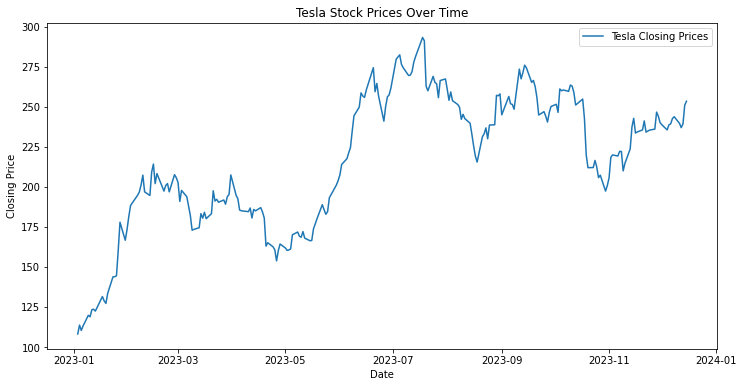

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Prices Over Time')
plt.legend()
plt.show()

# Histograms and Density Plots

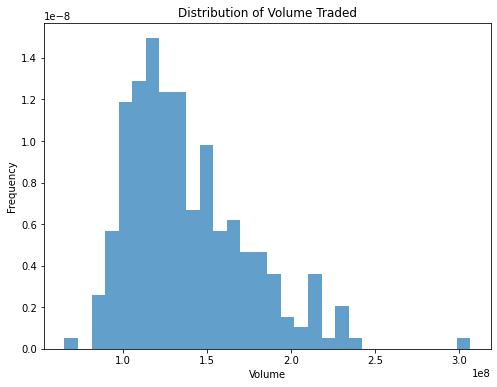

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(df['Volume'], bins=30, density=True, alpha=0.7)
plt.title('Distribution of Volume Traded')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

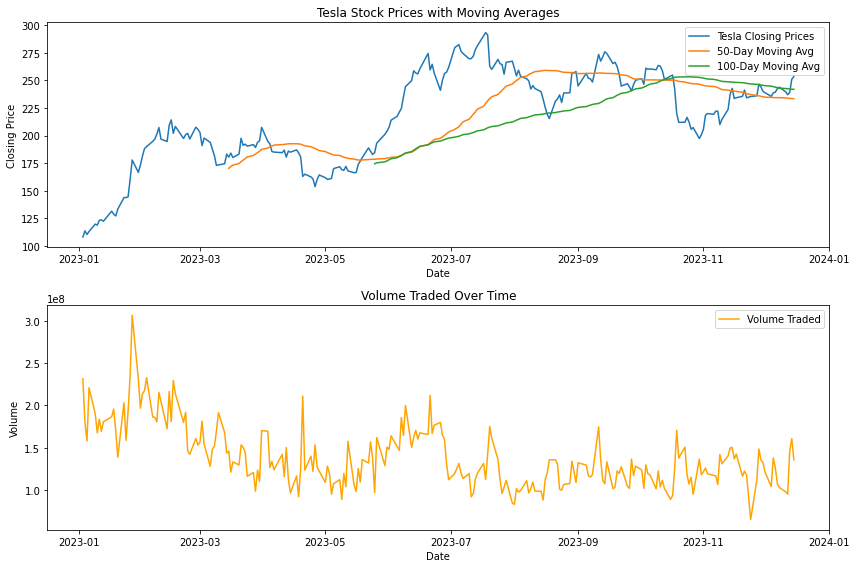

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.plot(df.index, df['Close'].rolling(window=50).mean(), label='50-Day Moving Avg')
plt.plot(df.index, df['Close'].rolling(window=100).mean(), label='100-Day Moving Avg')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Prices with Moving Averages')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df.index, df['Volume'], label='Volume Traded', color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Traded Over Time')
plt.legend()

plt.tight_layout()
plt.show()


# Volatility Analysis with Bollinger Bands:

C:\Users\anagh\AppData\Local\Temp\ipykernel_2484\2245766753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA'] = df['Close'].rolling(window=window).mean()


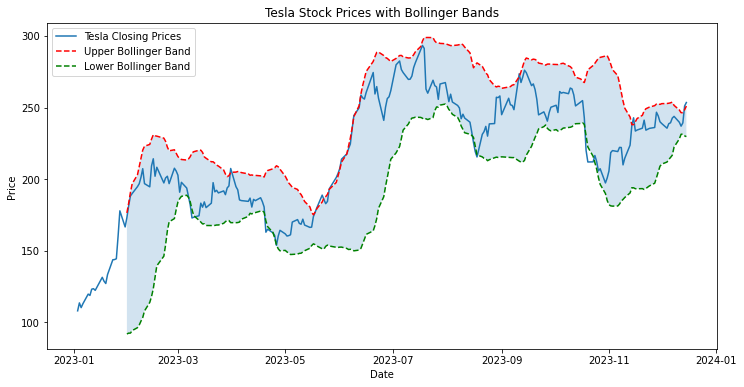

In [21]:
# Assuming '20' is used as the window for Bollinger Bands (you can adjust it)
window = 20

df['MA'] = df['Close'].rolling(window=window).mean()
df['STD'] = df['Close'].rolling(window=window).std()

df['UpperBand'] = df['MA'] + (df['STD'] * 2)
df['LowerBand'] = df['MA'] - (df['STD'] * 2)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.plot(df.index, df['UpperBand'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(df.index, df['LowerBand'], label='Lower Bollinger Band', linestyle='--', color='green')
plt.fill_between(df.index, df['UpperBand'], df['LowerBand'], alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tesla Stock Prices with Bollinger Bands')
plt.legend()
plt.show()


# Seasonality Analysis

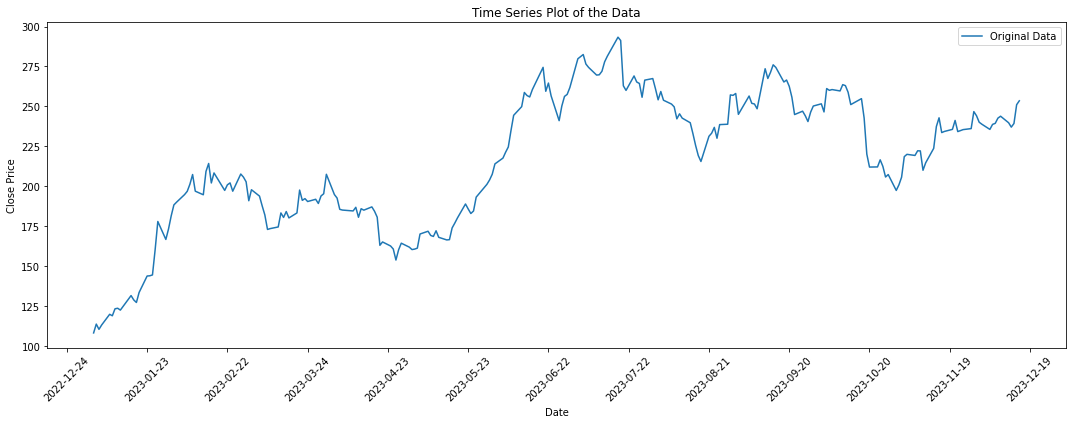

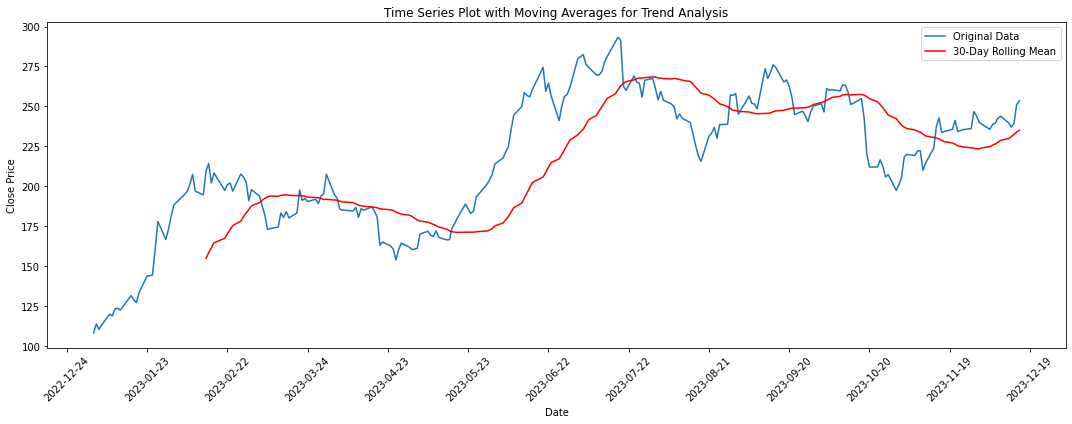

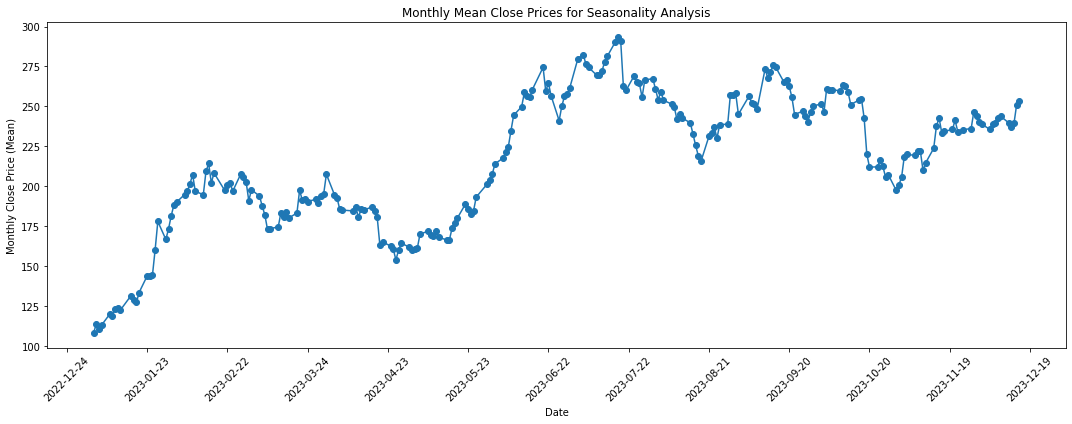

In [50]:
# Assuming df is your DataFrame with datetime index and 'Close' column
# If needed, convert index to datetime format
# df.index = pd.to_datetime(df.index)

# Plot the original time series data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='Original Data')
plt.title('Time Series Plot of the Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(13))  # Adjust the number of ticks as needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


# Calculate moving averages for trend analysis
window_size = 30  # Adjust window size as needed
rolling_mean = df['Close'].rolling(window=window_size).mean()

# Plot original data and moving averages
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='Original Data')
plt.plot(rolling_mean.index, rolling_mean, label=f'{window_size}-Day Rolling Mean', color='red')
plt.title('Time Series Plot with Moving Averages for Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(13))  # Adjust the number of ticks as needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


# Resample data to monthly frequency for seasonal analysis
# monthly_data = df['Close'].resample('M').mean()

# Plot monthly mean values to visualize seasonal patterns
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], marker='o', linestyle='-')
plt.title('Monthly Mean Close Prices for Seasonality Analysis')
plt.xlabel('Date')
plt.ylabel('Monthly Close Price (Mean)')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(13))  # Adjust the number of ticks as needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Extract the 'Close' column values and convert to a 2D numpy array
data = df['Close'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and test sets (e.g., 80% training, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences and their corresponding labels for the LSTM model
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Define sequence length (adjust as needed)
# Train the model on the entire dataset
X, y = create_sequences(scaled_data, sequence_length)
# Build the LSTM model with multiple layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50, return_sequences=True))  # Additional LSTM layer
model.add(LSTM(units=50))  # Additional LSTM layer
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=100, batch_size=32)  # Training on the whole dataset

# Generating future dates for prediction (next 5 years)
last_date = df.index[-1]  # Get the last date in your dataset
future_dates = pd.date_range(start=last_date, periods=1 * 12, freq='M')  # Assuming monthly predictions for 5 years

# Generate sequences for future predictions
last_sequence = scaled_data[-sequence_length:]  # Using the last sequence from the dataset
future_sequences = []
for i in range(len(future_dates)):
    next_sequence = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_sequences.append(next_sequence.flatten())
    last_sequence = np.append(last_sequence[1:], next_sequence, axis=0)

# Inverse transform the predicted sequences to original scale
future_sequences = scaler.inverse_transform(future_sequences)

# Create a DataFrame with future dates and predicted prices
future_df = pd.DataFrame(future_sequences, index=future_dates, columns=['Predicted'])

Epoch 1/100
8/8 [==============================] - 11s 31ms/step - loss: 0.2520
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 0.0380
Epoch 3/100
8/8 [==============================] - 0s 40ms/step - loss: 0.0173
Epoch 4/100
8/8 [==============================] - 0s 45ms/step - loss: 0.0188
Epoch 5/100
8/8 [==============================] - 1s 79ms/step - loss: 0.0140
Epoch 6/100
8/8 [==============================] - 1s 94ms/step - loss: 0.0107
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0101
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0095
Epoch 9/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0089
Epoch 10/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0087
Epoch 11/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0084
Epoch 12/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0088
Epoch 13/100
8/8 [==============================

1/1 [==============================] - 0s 41ms/step


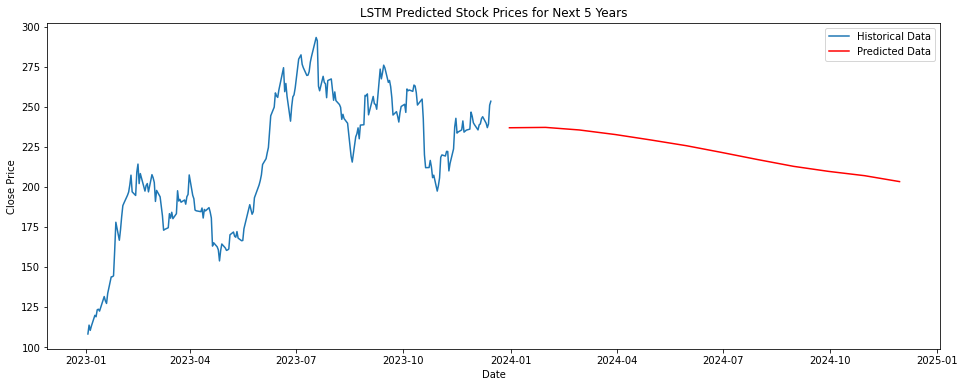

In [59]:
# Visualize the predicted stock prices for the next 5 years
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Historical Data')
plt.plot(future_df.index, future_df['Predicted'], label='Predicted Data', color='red')
plt.title('LSTM Predicted Stock Prices for Next 5 Years')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Epoch 1/150
6/6 [==============================] - 8s 23ms/step - loss: 0.1598
Epoch 2/150
6/6 [==============================] - 0s 32ms/step - loss: 0.0362
Epoch 3/150
6/6 [==============================] - 0s 28ms/step - loss: 0.0156
Epoch 4/150
6/6 [==============================] - 0s 29ms/step - loss: 0.0123
Epoch 5/150
6/6 [==============================] - 0s 30ms/step - loss: 0.0096
Epoch 6/150
6/6 [==============================] - 0s 29ms/step - loss: 0.0076
Epoch 7/150
6/6 [==============================] - 0s 25ms/step - loss: 0.0080
Epoch 8/150
6/6 [==============================] - 0s 29ms/step - loss: 0.0071
Epoch 9/150
6/6 [==============================] - 0s 26ms/step - loss: 0.0070
Epoch 10/150
6/6 [==============================] - 0s 26ms/step - loss: 0.0064
Epoch 11/150
6/6 [==============================] - 0s 28ms/step - loss: 0.0061
Epoch 12/150
6/6 [==============================] - 0s 26ms/step - loss: 0.0059
Epoch 13/150
6/6 [==============================]

6/6 [==============================] - 0s 22ms/step - loss: 0.0026
Epoch 104/150
6/6 [==============================] - 0s 26ms/step - loss: 0.0025
Epoch 105/150
6/6 [==============================] - 0s 23ms/step - loss: 0.0026
Epoch 106/150
6/6 [==============================] - 0s 22ms/step - loss: 0.0027
Epoch 107/150
6/6 [==============================] - 0s 24ms/step - loss: 0.0028
Epoch 108/150
6/6 [==============================] - 0s 24ms/step - loss: 0.0026
Epoch 109/150
6/6 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 110/150
6/6 [==============================] - 0s 21ms/step - loss: 0.0026
Epoch 111/150
6/6 [==============================] - 0s 22ms/step - loss: 0.0025
Epoch 112/150
6/6 [==============================] - 0s 26ms/step - loss: 0.0025
Epoch 113/150
6/6 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 114/150
6/6 [==============================] - 0s 22ms/step - loss: 0.0030
Epoch 115/150
6/6 [=======================

6/6 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 56/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 57/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 58/150
6/6 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 59/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 60/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 61/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 62/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 63/150
6/6 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 64/150
6/6 [==============================] - 0s 11ms/step - loss: 0.0019
Epoch 65/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 66/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 67/150
6/6 [==============================] - 0s 8ms/ste

1/1 [==============================] - 0s 35ms/step


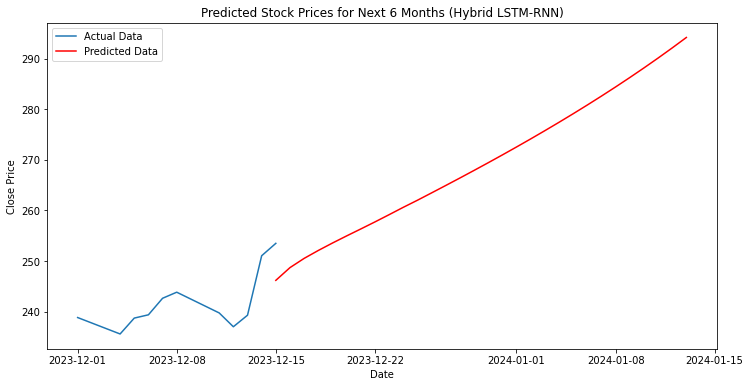

In [69]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load your dataset or assume 'df' as your DataFrame with datetime index and 'Close' column
# ... (Prepare your data)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare sequences for LSTM and RNN models
sequence_length = 10  # Define sequence length
X_train_lstm, y_train_lstm = create_sequences(train_data, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(test_data, sequence_length)

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(sequence_length, 1)))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=32)

# Simple RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(sequence_length, 1)))
rnn_model.add(SimpleRNN(units=100))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=32)


# Predict future stock prices for the next 6 months
future_steps = 1 * 30  # 6 months with 30 days per month

last_sequence = X_test_lstm[-1]
future_predictions = []

for i in range(future_steps):
    prediction = lstm_model.predict(last_sequence.reshape(1, sequence_length, 1))
    last_sequence = np.append(last_sequence[1:], prediction, axis=0)
    future_predictions.append(prediction)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps, freq='D')

# Visualize the predicted stock prices for the next 6 months
plt.figure(figsize=(12, 6))
plt.plot(df.index[-(sequence_length + 1):], df['Close'].values[-(sequence_length + 1):], label='Actual Data')
plt.plot(future_dates, future_predictions, label='Predicted Data', color='red')
plt.title('Predicted Stock Prices for Next 6 Months (Hybrid LSTM-RNN)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Epoch 1/150
6/6 [==============================] - 8s 19ms/step - loss: 0.2733
Epoch 2/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0445
Epoch 3/150
6/6 [==============================] - 0s 15ms/step - loss: 0.0378
Epoch 4/150
6/6 [==============================] - 0s 15ms/step - loss: 0.0090
Epoch 5/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0160
Epoch 6/150
6/6 [==============================] - 0s 18ms/step - loss: 0.0092
Epoch 7/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0090
Epoch 8/150
6/6 [==============================] - 0s 19ms/step - loss: 0.0078
Epoch 9/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0079
Epoch 10/150
6/6 [==============================] - 0s 18ms/step - loss: 0.0070
Epoch 11/150
6/6 [==============================] - 0s 19ms/step - loss: 0.0072
Epoch 12/150
6/6 [==============================] - 0s 24ms/step - loss: 0.0068
Epoch 13/150
6/6 [==============================]

6/6 [==============================] - 0s 16ms/step - loss: 0.0033
Epoch 104/150
6/6 [==============================] - 0s 19ms/step - loss: 0.0031
Epoch 105/150
6/6 [==============================] - 0s 18ms/step - loss: 0.0033
Epoch 106/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0033
Epoch 107/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0037
Epoch 108/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 109/150
6/6 [==============================] - 0s 17ms/step - loss: 0.0034
Epoch 110/150
6/6 [==============================] - 0s 17ms/step - loss: 0.0030
Epoch 111/150
6/6 [==============================] - 0s 17ms/step - loss: 0.0030
Epoch 112/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0030
Epoch 113/150
6/6 [==============================] - 0s 15ms/step - loss: 0.0030
Epoch 114/150
6/6 [==============================] - 0s 16ms/step - loss: 0.0032
Epoch 115/150
6/6 [=======================

6/6 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 56/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 57/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 58/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 59/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 60/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 61/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 62/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 63/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 64/150
6/6 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 65/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 66/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 67/150
6/6 [==============================] - 0s 9ms/step 

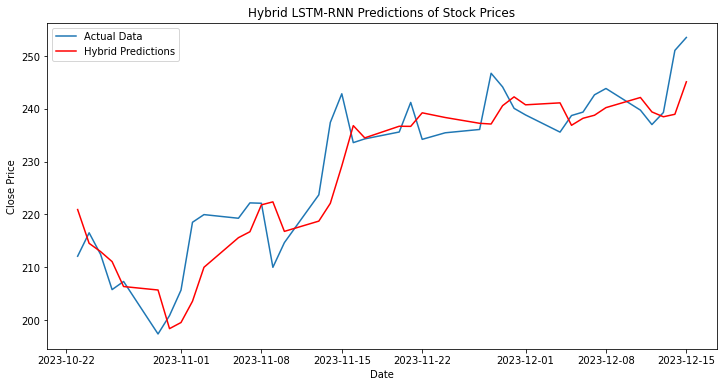

In [77]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame with datetime index and 'Close' column
# ... (Prepare your data)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare sequences for LSTM and RNN models
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10  # Define sequence length
X_train_lstm, y_train_lstm = create_sequences(train_data, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(test_data, sequence_length)

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=32)

# Simple RNN Model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
rnn_model.add(SimpleRNN(units=50))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=32)

# Generate predictions from both models
lstm_predictions = lstm_model.predict(X_test_lstm)
rnn_predictions = rnn_model.predict(X_test_lstm)

# Combine predictions (simple averaging)
combined_predictions = (lstm_predictions + rnn_predictions) / 2

# Inverse transform predictions to original scale
combined_predictions = scaler.inverse_transform(combined_predictions)

# Visualize the combined predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + sequence_length:], df['Close'].values[train_size + sequence_length:], label='Actual Data')
plt.plot(df.index[train_size + sequence_length:], combined_predictions, label='Hybrid Predictions', color='red')
plt.title('Hybrid LSTM-RNN Predictions of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [78]:
# Assuming 'combined_predictions' contains the predicted prices

if len(combined_predictions) > 0:
    initial_predicted_price = combined_predictions[0][0]  # Accessing the first element
    final_predicted_price = combined_predictions[-1][0]   # Accessing the last element

    estimated_percentage_change = ((final_predicted_price - initial_predicted_price) / initial_predicted_price) * 100

    print(f"Estimated Percentage Change based on Predictions: {estimated_percentage_change:.2f}%")
else:
    print("No predicted prices available.")


Estimated Percentage Change based on Predictions: 10.95%


In [79]:
# Assuming 'combined_predictions' contains the predicted prices

if len(future_predictions) > 0:
    initial_predicted_price = future_predictions[0][0]  # Accessing the first element
    final_predicted_price = future_predictions[-1][0]   # Accessing the last element

    estimated_percentage_change = ((final_predicted_price - initial_predicted_price) / initial_predicted_price) * 100

    print(f"Estimated Percentage Change based on Predictions: {estimated_percentage_change:.2f}%")
else:
    print("No predicted prices available.")


Estimated Percentage Change based on Predictions: 19.51%
